<table>
  <tr>
    <th>
      <img src="https://drive.google.com/uc?id=1GLaeRA1-wxlBJZITccZTLOkYKK5Z78gS", height = "125", alt="RI-INBRE Logo">
    </th>
    <th>
    <img src="https://drive.google.com/uc?id=1iHm7uZymx9IrwWQnCoUWtpGvdHVLZBFA", height = "125", width="500", alt="MIC Logo">
    </th>
  </tr>
</table>

---

# Analysis of Biomedical Data for Biomarker Discovery
## Submodule 4: Introduction to Exploratory Analysis
### Dr. Christopher L. Hemme
### Director, [RI-INBRE Molecular Informatics Core](https://web.uri.edu/riinbre/mic/)
### The University of Rhode Island College of Pharmacy
Last Updated: March 22, 2023

---

## Introduction

Once data has been generated from experiments, we begin the process of data analysis.  Traditionally this consisted primarily of <b>statistical hypothesis testing</b>, in which the scientist generates a set of null and alternative hypotheses which can be tested experimentally.  For example, let's say we're testing a new Wonder Drug B to see if it reduces blood pressure better than Wonder Drug A.  We might set up the following null ($H_0$) and alternative ($H_1$) hypotheses:

$$H_0 = \text{Wonder Drug B does not significantly lower blood pressure compared to Wonder Drug A}$$
$$H_1 = \text{Wonder Drug B significantly lowers blood pressure compared to Wonder Drug A}$$

We would then set up the experiment, analyze it with a one-tailed <i>t</i>-test at a significance level of <i>p</i> = 0.05, and then determine if the null hypothesis can be rejected.  Statistical hypothesis testing is a well-established method, and while it has its short-comings, is still a cornerstone of data analysis.

In recent decades, increased emphasis has been placed on <b>exploratory data analysis</b> or <b>EDA</b>.  Intended as a compliment to statistical hypothesis testing, EDA gives us a broader, bird's eye view of the data that can be used to guide hypothesis building, identify hidden trends in data, and to suggest statistical methods for analysis.  EDA can range from simple methods such as scatter plots and heatmaps to more complex methods such as dimensionality reduction and clustering.  Visualization is a key component of EDA, particularly for large high-dimensional datasets that would be difficult to visualize using traditional methods.

EDA is very common when analyzing omics data, which is usually high-dimensional data with many of the variables highly correlated.  In this submodule, we will look at some common general methods of EDA that you will likely encounter when working with omics data, including heatmaps and principal component analysis.  Methods more specific to omics data such as volcano plots and MA plots are discussed in <b>Submodule 4: Exploratory Analysis of Proteomics IRI Data</b>.

<div class="alert alert-block alert-info">
<b>&#9995; Tip:</b> Blue boxes will indicate helpful tips.</div>

<div class="alert alert-block alert-warning">
<b>&#127891; Note:</b> Used for interesting asides or notes.
</div>

<div class="alert alert-block alert-success">
<b>&#9997; Reference:</b> This box indicates a reference for an attached figure or table.
</div>

<div class="alert alert-block alert-danger">
<b>&#128721; Caution:</b> A red box indicates potential hazards or pitfalls you may encounter.
</div>

---

## Load R Modules

In [22]:
packages <- c("heatmaply", "GGally", "plotly")
installed_packages <- packages %in% rownames(installed.packages())
if (any(installed_packages == FALSE)) {install.packages(packages[!installed_packages])}

# plotly creates interactive web graphics
# heatmaply creates interactive heatmaps based on plotly and ggplot2
# GGally is an extension of ggplot2

In [21]:
require('tidyverse')
require('plotly')
require('heatmaply')
require('RColorBrewer')
require('GGally')
require('factoextra')
require('cluster')
require('dendextend')

In [23]:
# factoextra visualizes results of multivariate data analysis
# This must be done after the require() statements in order to avoid overwriting certain packages
if(!require(devtools)) install.packages("devtools")
devtools::install_github("kassambara/factoextra")
library("factoextra")

Skipping install of 'factoextra' from a github remote, the SHA1 (1689fc74) has not changed since last install.
  Use `force = TRUE` to force installation



---

## Simple Descriptive Graphs

For low dimensionality data, simple graphs are often sufficient to highlight properties of the data.  Consider the <b>iris</b> dataset built into R which describes three species of iris based on four physical properties.

In [4]:
iris # print out iris data
summary(iris) # calculate summary statistics for iris data

Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
5.1,3.5,1.4,0.2,setosa
4.9,3.0,1.4,0.2,setosa
4.7,3.2,1.3,0.2,setosa
4.6,3.1,1.5,0.2,setosa
5.0,3.6,1.4,0.2,setosa
5.4,3.9,1.7,0.4,setosa
4.6,3.4,1.4,0.3,setosa
5.0,3.4,1.5,0.2,setosa
4.4,2.9,1.4,0.2,setosa


  Sepal.Length    Sepal.Width     Petal.Length    Petal.Width   
 Min.   :4.300   Min.   :2.000   Min.   :1.000   Min.   :0.100  
 1st Qu.:5.100   1st Qu.:2.800   1st Qu.:1.600   1st Qu.:0.300  
 Median :5.800   Median :3.000   Median :4.350   Median :1.300  
 Mean   :5.843   Mean   :3.057   Mean   :3.758   Mean   :1.199  
 3rd Qu.:6.400   3rd Qu.:3.300   3rd Qu.:5.100   3rd Qu.:1.800  
 Max.   :7.900   Max.   :4.400   Max.   :6.900   Max.   :2.500  
       Species  
 setosa    :50  
 versicolor:50  
 virginica :50  
                
                
                

There are several basic plots we can use to summarize the data.  First, is the scatter plot of two variables.  If you completed <b>Submodule 7: Introduction to Linear Models</b>, we made a scatterplot of the Petal Length vs. Sepal Length and colored the data points by Species so that we could identify trends in the data before conducting linear regression.

`geom_smooth()` using formula = 'y ~ x'


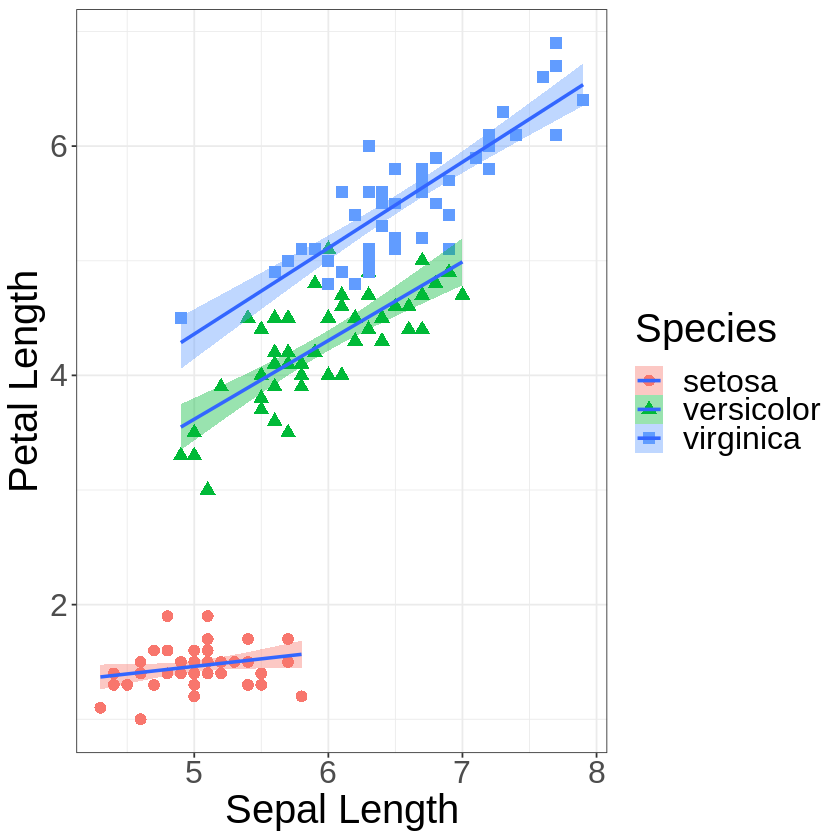

In [5]:
iris_scatter <- iris %>%
    ggplot(aes(x = Sepal.Length, y = Petal.Length)) +
        geom_point(size = 3, aes(color = Species, shape = Species)) +
        xlab("Sepal Length") +
        ylab("Petal Length") +
        geom_smooth(method="lm", aes(fill=Species)) +
        theme_bw() +
        theme(text=element_text(size = 24))
iris_scatter

# basic scatter plot (geom_point) that sets the colors and shape of the data points by Species
# We add a trend line (geom_smooth) based on linear regression (method="lm") using the default formula y ~ x
# We modify geom_smooth with an aesthetic (aes(fill=Species)) to fit each Species separately

We can clearly see that each species has a different relationship between the two variables.  Another way of dealing with this data is with a box plot.

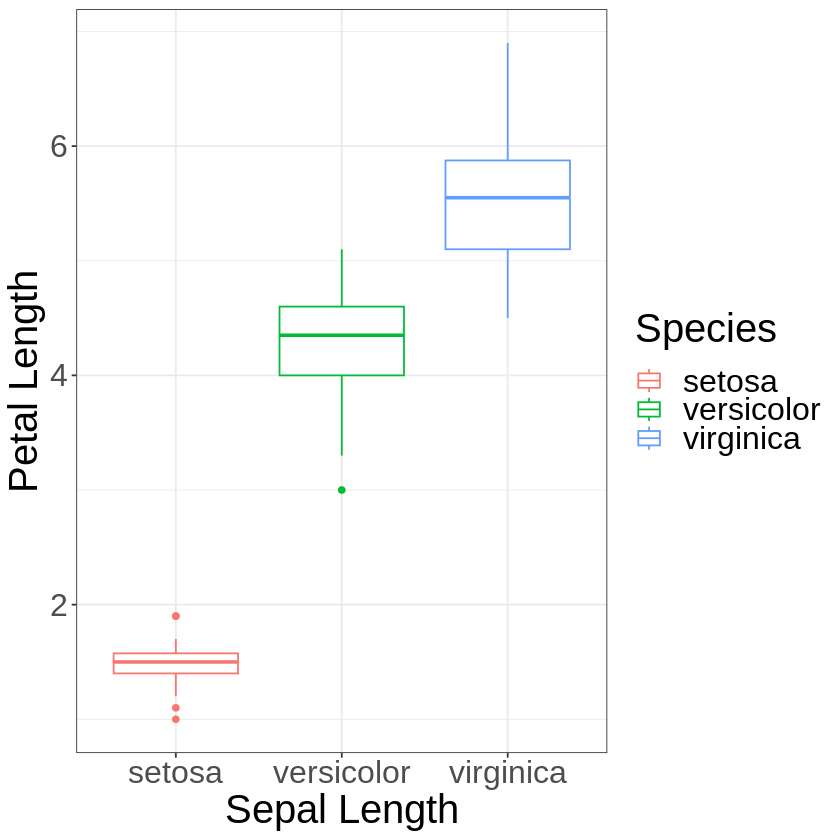

In [6]:
iris_box <- iris %>%
    ggplot(aes(x = Species, y = Petal.Length)) +
        geom_boxplot(aes(color = Species)) +
        xlab("Sepal Length") +
        ylab("Petal Length") +
        theme_bw() +
        theme(text=element_text(size = 24))
iris_box

# basic box plot (geom_boxplot) that sets the colors boxes by Species

The box plot (also called a box and whisker plot) is extremely useful for visualizing descriptive statistics and identifying outliers.  How do we interpret this plot?  The box scales between the 1st and 3rd quartiles, representing ~50% of the data (also called the <b>interquartile range</b> or <b>IQR</b>.  This gives an indication of the spread of the data.  The whiskers indicate the maximum and minimum values of the data and identifies outliers which are presented as dots.  Outliers are points that lie outside of an established range, usually outside $\pm1.5\;\text{IGR}$.  The line in the middle of the box is the median, that is, the middle value that separates 50% of the data.

Let's add the actual data points.  We'll add a bit of noise to the data using <b>geom_jitter</b> to make it easier to see the individual points.

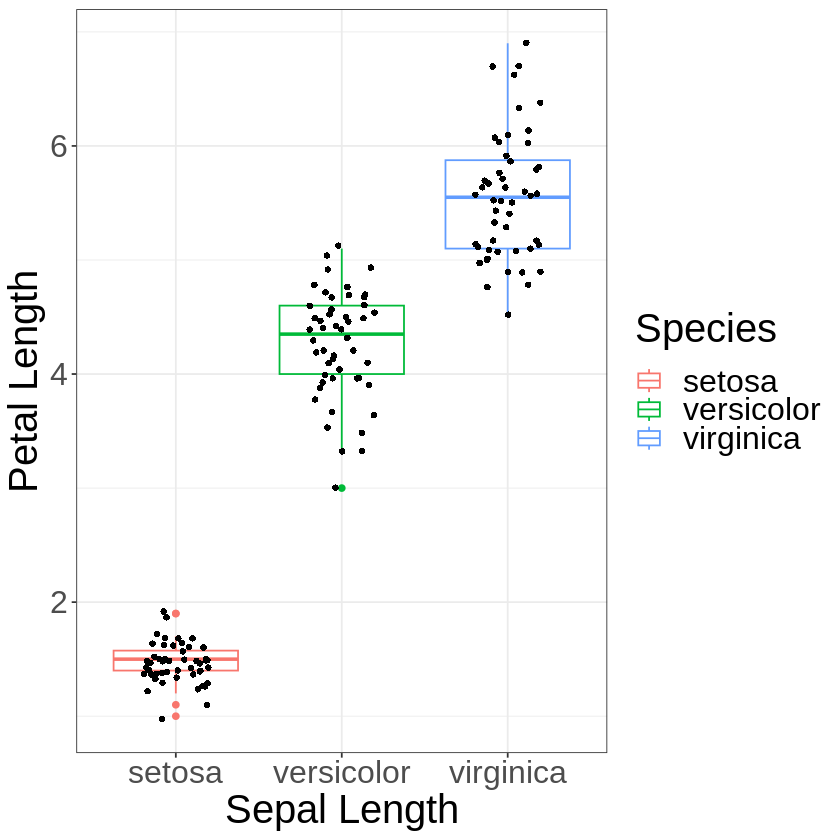

In [7]:
iris_box + geom_jitter(shape=16, position=position_jitter(0.2))

# The shape argument sets the shape to filled circle.  We can adjust the position_jitter number to add more or less noise.

We can see the separation of the data by Species very clearly with the box plot.  We can also predict what the results of further analysis such as ANOVA will tell us, i.e., that significant differences between the means of the three species exist.  Often you might see box plots attached to other plots (e.g., placed on the axis of a heatmap) or overlaid with additional information (e.g., ANOVA results).  Box plots are also useful in visualizing data normalization to determine if your data is ready for further analysis.  That said, we need to be careful in interpreting the box plot.  Data with a large spread may look significantly different when plotting but may show no statistically significant differences when analyzed by more comprehensive statistical methods.  Like all exploratory analysis, the box plot is a guide that helps to understand patterns in your data but needs to be backed up with more rigorous methods.

---

### Heatmaps

Another useful visualization tool, especially for big data sets, is the heatmap.  Consider a bar plot in three dimensions, with the vertical dimension representing some response variable.  A 3D bar plot is difficult to visualize on a 2D screen which makes interpretation difficult.  But what if we color the bars based on the value of the response variable and then look at the plot from above?  Now we have a two dimensional grid where the value of the response variable has been converted to color, with the color range representing the range of values.  Not only is this plot easier to read, but by clustering the rows and columns of the plot, we can identify global patterns in the data that are not immediately obvious when visualizing it in other ways.  This is the basis of the heatmap, a very common visualization format in omics data analysis. 

<div class="alert alert-block alert-info">
<b>&#9995; Tip:</b> Because the heatmap is such a common visualization tools, there are dozens of packages available in R for creating them.  We'll use the <b>heatmaply</b> package here and in <b>Submodule 5: Identification of IRI Biomarkers from Proteomic Data</b>, we'll use the <b>ComplexHeatmap</b> package which is specialized for omics data.  <b>heatmaply</b> is compatable with <b>ggplot2</b> and tidy principles and allows us to create interactive heatmaps.  <b>heatmaply</b> allows you to zoom in on regions of the global heatmap to get a better view of particular regions.</div>

<div class="alert alert-block alert-danger">
<b>&#128721; Caution:</b> While heatmaps are useful for visualizing big data sets, they can also become very crowded and difficult to read.  Also, the choice of colors is critical to interpreting the heatmap.  A poor choice of colors can lead to confusion, imply false patterns, or complicate visualization by color-blind viewers.
</div>

In [37]:
#iris_subset <- iris[1:4] # limit to numerical columns
#heatmaply(iris_subset) # plot heatmap

# heatmaply may take a few seconds to create the heatmap, particularly for large datasets.

library(plotly)
library(ggplot2)
df = data.frame(X =c(1:5),  Y=c(2:6) )
gg <- ggplot(df, aes(x=X,y=Y))+geom_point()
ggplotly(gg)
ggplotly(gg)

Output hidden; open in https://colab.research.google.com to view.

We can start to see patterns in the data, but the range is very broad.  In some omics datasets where the range of values is very large and the count matrix is sparse (e.g., many cells are zero), a heatmap of the raw data will be a giant uninformative blob of the low range color.  To better distinguish the differences, we should first normalize the data.  There are many ways to normalize data, but for this dataset, we will use <b>heatmaply's</b> built-in <b>normalize</b> function which normalizes the data to between 0 and 1 by subtracting the minimum value of the dataset from each data point and dividing by the maximum value.

In [9]:
iris_norm <- normalize(iris_subset) # normalization function
heatmaply(iris_norm)

Output hidden; open in https://colab.research.google.com to view.

Now the patterns are more clear.  We can see that the Sepal.Width data is distinct from the other three variables, and that Petal.Length and Petal.Width are similar to each other.  The tree-like structures on the top and right are <b>dendrograms</b> that indicate relationships between the columns and rows, respectively.  The rows and columns have been rearranged through <b>hierarchical clustering</b> to place similar rows or columns together.  This can be very useful in pattern identification because it tends to create a box-like structure to the heatmap.  Sometimes though, we might not want this clustering to occur.  For example, we might want similar samples to be together so we can see patterns within the group, or we might want genes arranged in chromosomal order.  In such cases, we can turn the clustering off.

In our case, we'll leave the clustering on because we want to see if the arrangement of the rows corresponds to species.  We can tell by the row dendrogram that there are 3-5 clusters, and we know from the raw data that we have 3 species.  Let's clean up our heatmap a bit to find out how well our data is really organized.  We'll recolor the heatmap using <b>RColorBrewer</b>, a popular package that provides a variety of color palettes.  We'll color the dendrogram based on clusters defined by <b>k-means clustering</b> and we'll set the number of clusters to 3 since we know that's how many species we have.  Finally, we will add a coloun that is colored by Species so that we can compare to the clusters chosen algorithmically.

<div class="alert alert-block alert-warning">
<b>&#127891; Note:</b> We'll discuss clustering methods later in this module.
</div>

In [10]:
heatmaply(
    iris_norm,
    colors = colorRampPalette(brewer.pal(3, "BuPu")), # Uses "Blue-Purple" color palette
    k_row = 3, # k-means clustering assuming three clusters
    row_side_colors = iris[, 5] # sets row side colors based on Species
)

Output hidden; open in https://colab.research.google.com to view.

As expected, one of the clusters defined by the k-means algorithm corresponds to the setosa samples, which seem to have larger than average sepal width but smaller sepal lengths, petal lengths, and petal widths.  The virginica and versicolor samples don't separate as cleanly.  Depending on the dataset, a pattern like this could indicate relevant subpopulations or it could just be the results of noise in the data.  In the case of iris, we can see from the scatterplots that while versicolor and virginica are distinct, there is still some overlap in the two groups.

---

## Dimensionality Reduction

The heatmaps begin to give us an idea of how the iris dataset is organized.  We can begin to see patterns in the data that indicate why the species differ.  In particular, Sepal Length, Petal Length and Petal Width seem to show similar patterns, suggesting they are correlated.  We can check this using a scatter plot matrix, that is, create scatterplots of every pair of variables.  We'll use the <b>plotly</b> and <b>ggally</b> packages to do this, specifically the <b>ggpairs</b> function.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


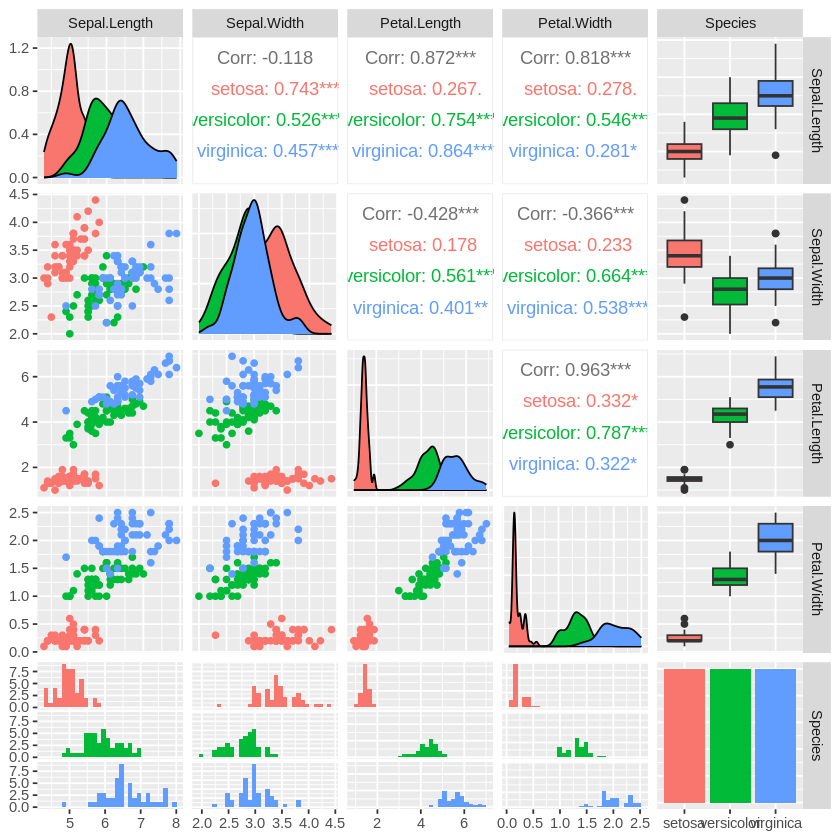

In [11]:
ggpairs(iris,
        aes(colour = Species)
       )

There is a lot of data in this figure.  The diagonal shows density plots for each variable separated by species.  The right hand column shows the bar plots for each variable and the bottom row shows histograms for each variable.  The lower triangle shows the scatterplots and the upper triangle shows the correlation coefficients for each variable by species (correlation coefficient ranges between 0 (no correlation) and 1 (perfect correlation)).  We can now start to see patterns in the variables, particularly in which variables might be correlated (see the correlation coefficient for each pair).

This is fine for four variables, but what if we were analyzing an omics data set with 4000 variables?  For high dimension data, the number of variables to consider is so high that it significantly decreases the accuracy of our models.  This is particularly problematic with omics data where we assume that most features won't be relevant to our models (e.g., most genes won't be differentially expressed between most conditions).  We call this problem the <b>curse of dimensionality</b>.  We could combat it by adding more data, but this isn't always feasible.  Alternatively, we can reduce the number of features, resulting in a simpler dataset where groups of correlated variables are transformed to a smaller number variables that best explain the system.  We call this process <b>dimensionality reduction</b> and the best known method is <b>principal component analysis (PCA)</b>.

Consider the following 2D scatter plot.  We can see that there is a correlation between these two variables and that both the x and y axes contribute to the variability in the sample. 

<div>
  <img src="https://drive.google.com/uc?id=1j5sehUE1S7cif_jyjnU-rGEWIFU0xgpH", alt="PCA1">
</div>

The variability of the dataset can be described by the <b>covariance matrix</b> from which we can identify a new axis called a <b>principal component</b>, or <b>PC</b>.  The first PC (PC1) is oriented along the direction of the highest variance in the data.  When this variance is accounted for, a second PC (PC2) can be calculated along the direction of the second highest variance, and so on until all of the variance has been accounted for.  The data points are transformed based on the new variables represented by the PC's and the PC's are rotated to orient them along traditional horizontal and vertical lines that we're familiar with.

<div class="alert alert-block alert-warning">
<b>&#127891; Note:</b> To put it another way, the PC's are linear combinations of the observed variables.  The PCA algorithm is calculating a new origin and building a multidimensional oval around the data defined by the magnitude and length of the PC's.  It's important to note that unlike the original data points, the values of the transformed data points plotted on the PCA have no inherent experimental meaning.
</div>

<div>
  <img src="https://drive.google.com/uc?id=1vGfY_nRUgJcQDanataTJlfpJLXF0zgrt", alt="PCA2">
</div>


<div>
  <img src="https://drive.google.com/uc?id=1_UQImg0FdT0HEvmKsjkdM5jL6WNNRzsa", alt="PCA3">
</div>

The data is transformed and rotated into a new coordinate system, where the new axes (the PC's) are independent of each other and define the amount of variable along a given axis.  In this hypothetical example, PC1 accounts for 80% of the variability and PC2 the remaining 20%.

More formally, we are calculating the <b>eigenvectors</b> and <b>eigenvalues</b> of the covariance matrix.  The eigenvectors represent the orientation (direction) of the new PC's compared to the original data and the eigenvalues are the covariance (magnitude) along the new PC's.

PCA is thus decomposing the data matrix <b>X</b> into matrices <b>U</b> and <b>V</b>, where

$$X = A \cdot B = AB^T$$

$A$ = Scores matrix, which is the original data rotated into the new coordinate system

$B$ = Loadings matrix, which is the weights applied to each data point in the new coordinate system

Now let's use R's <b>prcomp</b> function to analyze the iris data set.

<div class="alert alert-block alert-info">
<b>&#9995; Tip:</b> As with heatmaps, PCA is so commonly used that you can find dozens of packages for conducting and visualizing PCA.  We'll use base R functions here.</div>

Importance of components:
                          PC1    PC2     PC3     PC4
Standard deviation     1.7084 0.9560 0.38309 0.14393
Proportion of Variance 0.7296 0.2285 0.03669 0.00518
Cumulative Proportion  0.7296 0.9581 0.99482 1.00000

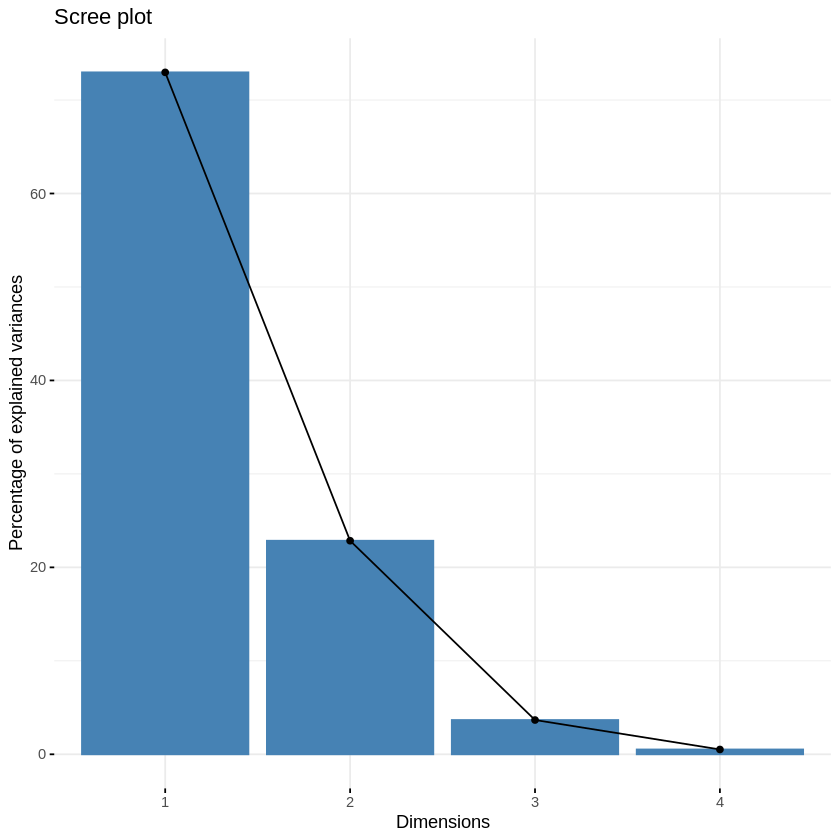

In [12]:
iris.pca <- prcomp(iris[,1:4], scale = TRUE, center = TRUE) # run PCA analysis, scaling the data to unit variance and centering on zero.
summary(iris.pca) # summarize the PCA output
fviz_eig(iris.pca) # plot scree plot

As with heatmaps, it's important to normalize data before running PCA.  Otherwise, the first PC will likely contain more variance than expected.  For this example, we'll simply scale the data using <b>prcomp</b>'s scale argument.  We can see from the output the individual and cumulative variance associated with each PC, and we can plot that as a <b>scree plot</b> (also called an <b>elbow plot</b>.  We can see that PC1 accounts for ~73% of the variance and PC2 23%, for a total of 95%.  This means that we can ignore PC3 and PC4 without losing much information.  Let's see what a scatterplot of PC1 and PC2 looks like.

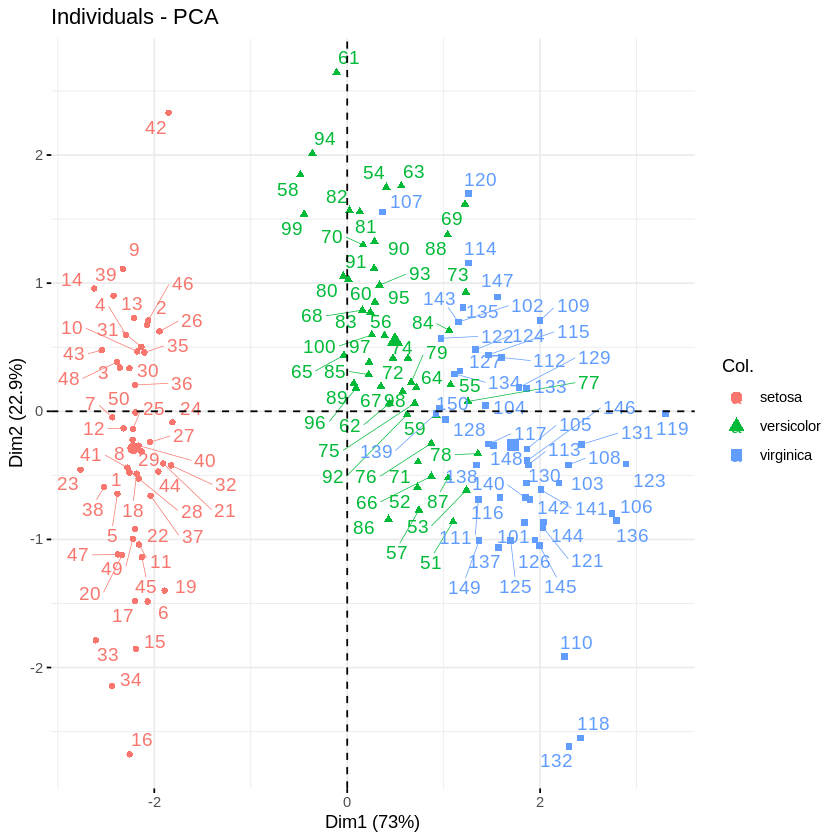

In [13]:
fviz_pca_ind(iris.pca,
             col.ind = iris$Species,
             repel = TRUE
             )

# plot individual data points, colored by Species, using factoextra package

All three species, especially setosa, are separated along PC1.  There is some separation along PC2, but it doesn't look particularly meaningful.  What's driving this separation?  To determine that, we need to look at the <b>loading plot</b>.

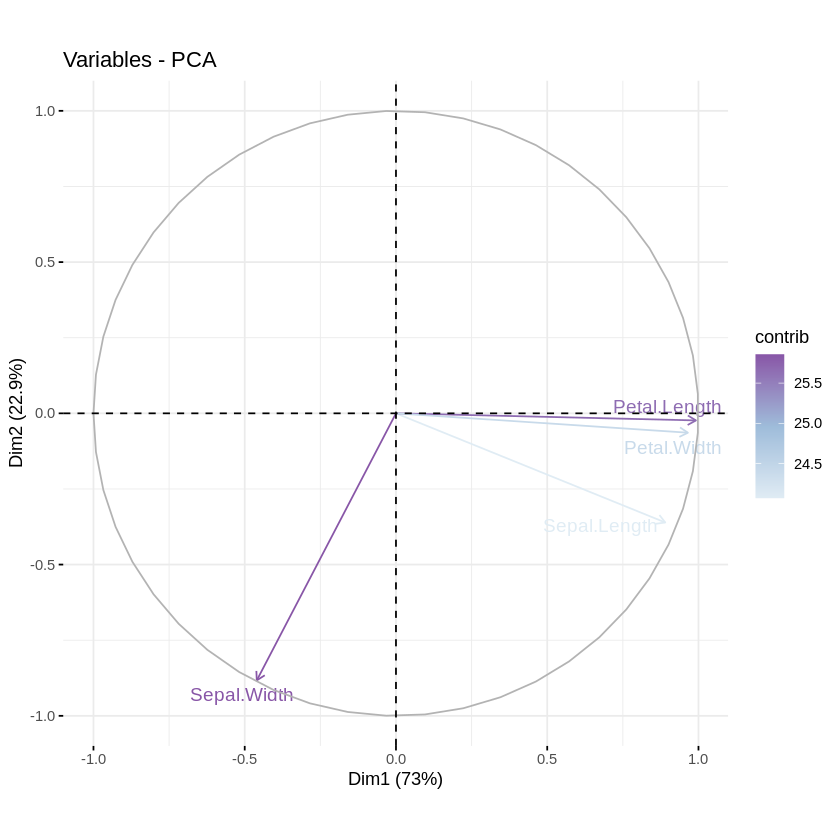

In [14]:
fviz_pca_var(iris.pca,
             col.var = "contrib",
             gradient.cols = c("#E0ECF4", "#9EBCDA", "#8856A7"),
             repel = TRUE
             )

# plot variable loading plot, colored by relative contribution, using factoextra package

Petal Length and Sepal Length have the strongest contribution.  Sepal Length acts along both PCs and shows a negative correlation for both.  Petal Length is almost solely associated with PC1 and is likely causing the separation of the species data point.  Petal Length, Petal Width and Sepal Length all trend in the same general direction, suggesting that these variable are correlated.  This is consistent with what we see from the scatterplots above.

We can combine these two plots into a <b>biplot</b>.

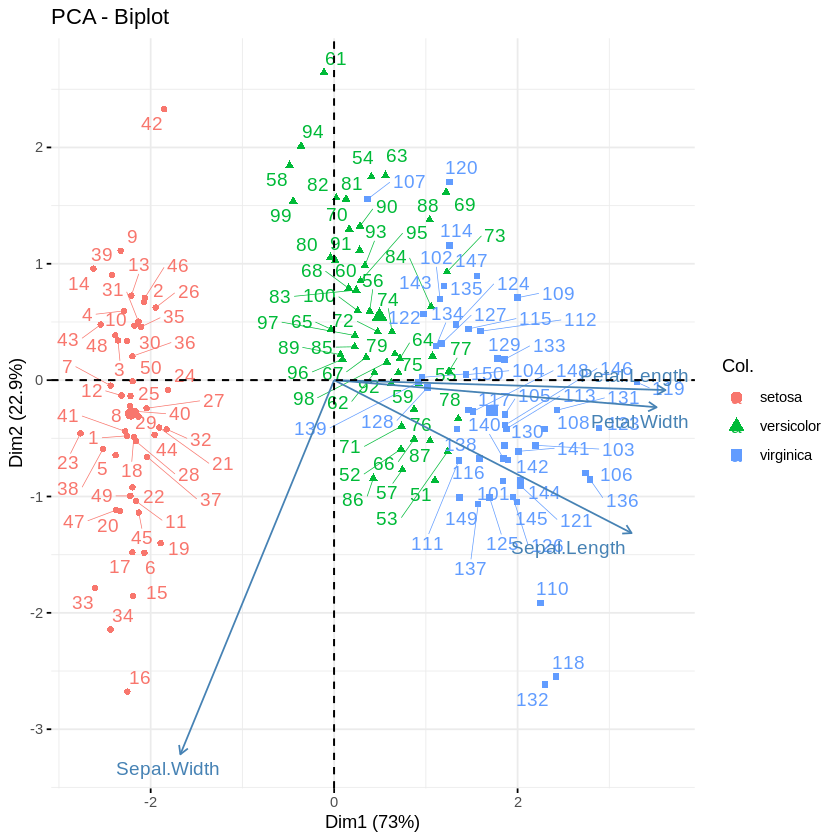

In [15]:
fviz_pca_biplot(iris.pca, repel = TRUE,
                col.ind = iris$Species
                )

# plot biplot using factoextra package

The PCA plot has many uses beyond identifying interesting clusters.  It is commonly used to identify batch effects in omics data which have to be accounted for in regression models (see <b>Submodule 4: Exploratory Analysis of Proteomics IRI Data</b> for an example).  PCA can also be used as a precursor to regression analysis or k-means clustering to simplify the data sets and reduce noise.  PCA is related to many other dimensionality reduction techniques (either conceptually or mathematically) such as factor analysis, discriminant analysis, multidimensional scaling, and t-SNE.

---

## Clustering Algorithms

PCA and other dimensionality reduction methods are often used to identify clusters of similar data points.  However, PCA looks at the entire dataset and does not take into account similarity data between data points.  Any separation is a consequence of the dimensionality reduction and will only happen if there is sufficient variance associated with the PC's.  <b>Clustering algorithms</b>, by contrast, look for relationships between the data points themselves to identify shared properties within the clusters.

There are many ways to cluster data and many properties that we can cluster by.  Phylogenetic trees, for instance, can be built from distance matrices based on similarity between the sequences used to build the tree.  We also use dissimilarity matrices to measure ecological diversity within and between populations.  Clustering is also an important tool in machine learning.  In this submodule, we will only look at the two most common methods, both of which we've seen before with our heatmaps: <b>hierarchical clustering</b> and <b>k-means clustering</b>.

---

### Hierarchical Clustering

<b>Hierarchical Cluster Analysis (HCA)</b> is probably the most well-recognized clustering method.  This is often the basis of the classic tree structure (<b>dendrogram</b>) that we used for clustering the heatmaps above.  There are many ways to perform HCA but it's common to build a distance matrix (often based on Euclidean distance) that numerically defines how dissimilar two data points are.  We can then use that information to build a dendrogram.

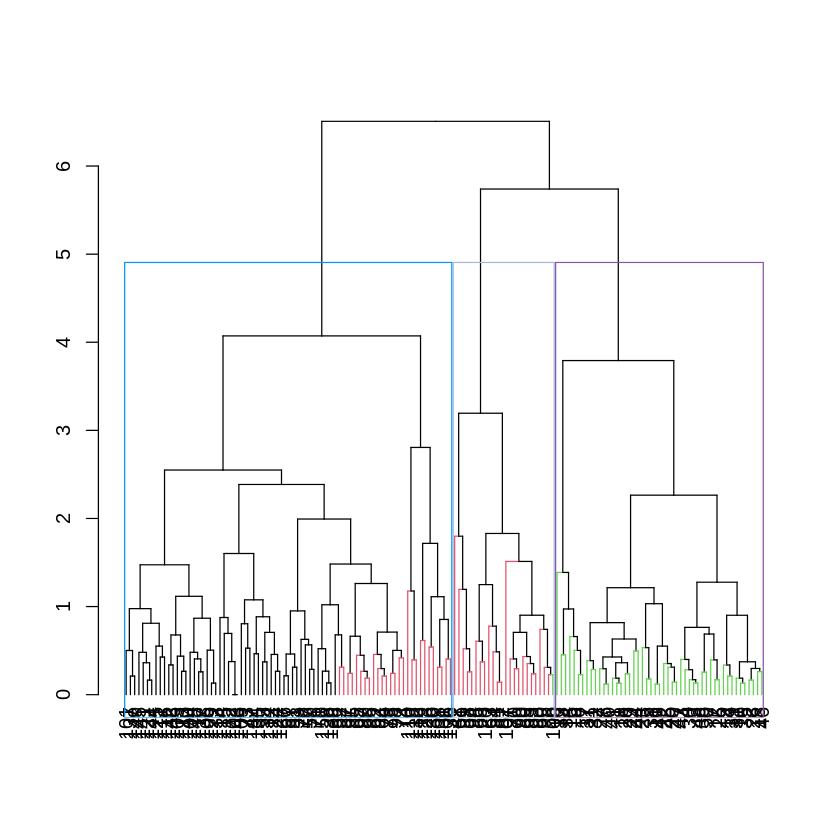

In [16]:
dist_iris <- dist(scale(iris[,1:4]), method = "euclidean") # calculate Euclidean distances
hca_iris <- hclust(dist_iris, method = "complete") # cluster using "complete linkage" method
dend_iris <- as.dendrogram(hca_iris) # create dendrogram
dend_iris_color <- color_branches(dend_iris, col = iris$Species) # color branches by Species
plot(dend_iris_color) # plot the dendrogram
rect.hclust(hca_iris, k = 3, border = c("#0295f7", "#9EBCDA", "#8856A7")) # add colored boxes defining k-means clusters (k = 3)

This is exactly what we saw before.  Setosa separates cleanly, virginica and versicolor not quite as cleanly.  Feel free to try different distance and clustering methods to see how it affects the results.

---

### k-Means Clustering

<b>k-Means Clustering</b> is one of the most common clustering methods.  We first dictate how many clusters (k) we expect to find in our data.  The algorithm then identifies k random "centroids" around which to build the clusters.  This is an iterative process that assigns data points to clusters in a way that minimizes the in-cluster variance (Total Within Sum of Squares).

How do we choose k?  For iris, we would expect three clusters, one for each species.  If we didn't know this beforehand, however, we would have to determine the optimal number of clusters computationally.  The simplest way to do this is to use an <b>elbow plot</b>. An elbow plot is the plot of the number of clusters vs. the total within sum of squares calculated by the k-means algorithm.  The bend in the plot (the elbow) indicates the optimal number of clusters.  In this case, 3 seems like a good choice.

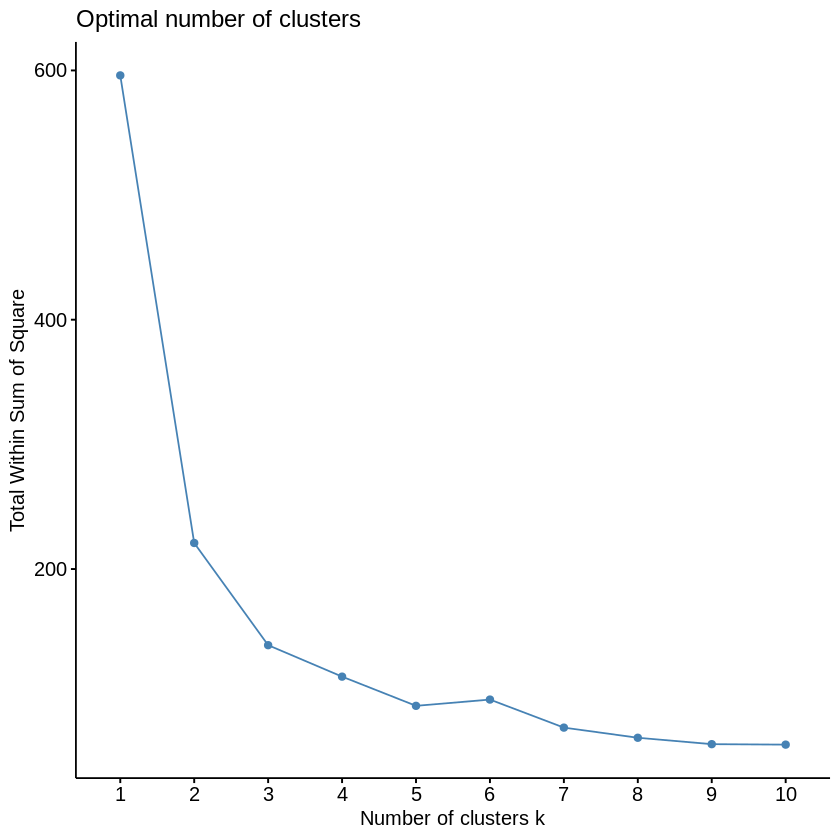

In [17]:
iris_scale <- scale(iris[,1:4]) # scale the iris data
fviz_nbclust(iris_scale, kmeans, method = "wss") # create the elbow plot using k-means clustering

In [18]:
iris_kmeans <- kmeans(iris_scale, 3) # run the k-means algorithm on iris assuming three clusters
iris_kmeans

K-means clustering with 3 clusters of sizes 33, 21, 96

Cluster means:
  Sepal.Length Sepal.Width Petal.Length Petal.Width
1   -0.8135055   1.3145538   -1.2825372  -1.2156393
2   -1.3232208  -0.3718921   -1.1334386  -1.1111395
3    0.5690971  -0.3705265    0.6888118   0.6609378

Clustering vector:
  [1] 1 2 2 2 1 1 1 1 2 2 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 2 1 1 1 2 2 1
 [38] 1 2 1 1 2 2 1 1 2 1 2 1 1 3 3 3 3 3 3 3 2 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3
 [75] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3
[112] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[149] 3 3

Within cluster sum of squares by cluster:
[1]  17.33362  23.15862 149.25899
 (between_SS / total_SS =  68.2 %)

Available components:

[1] "cluster"      "centers"      "totss"        "withinss"     "tot.withinss"
[6] "betweenss"    "size"         "iter"         "ifault"      

We have three clusters of size 53, 47 and 50, respectively.  Remember that our species are evenly sized at 50, so we can already see that our clustering is not perfect.  Let's plot the data and see what it looks like.

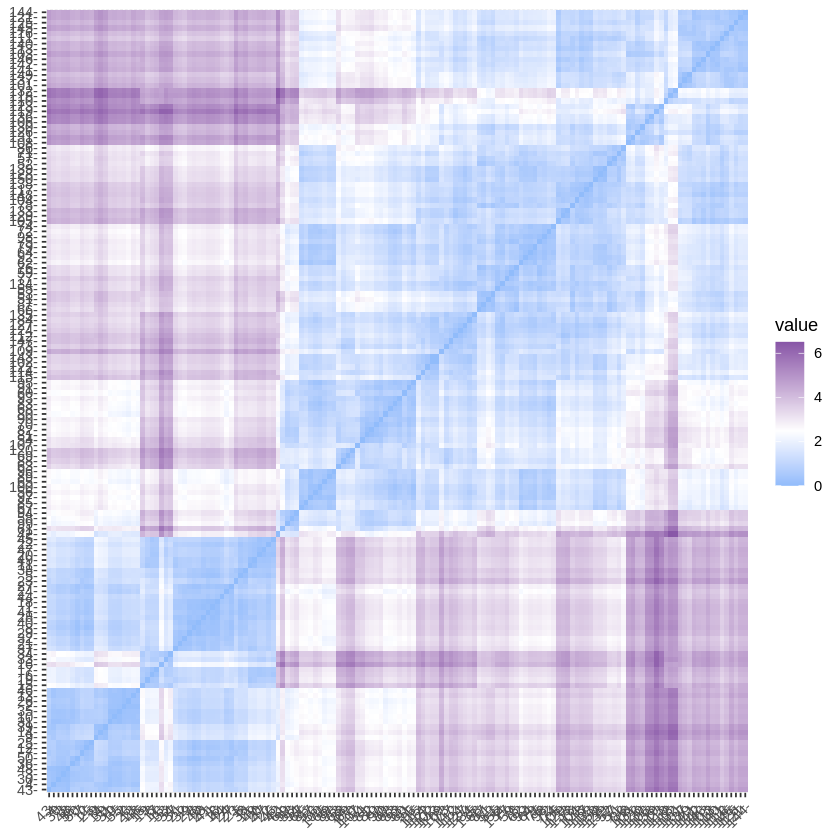

In [19]:
iris_distance <- get_dist(iris_scale)
fviz_dist(iris_distance, gradient = list(low = "#0295f7", mid = "white", high = "#8856A7"))

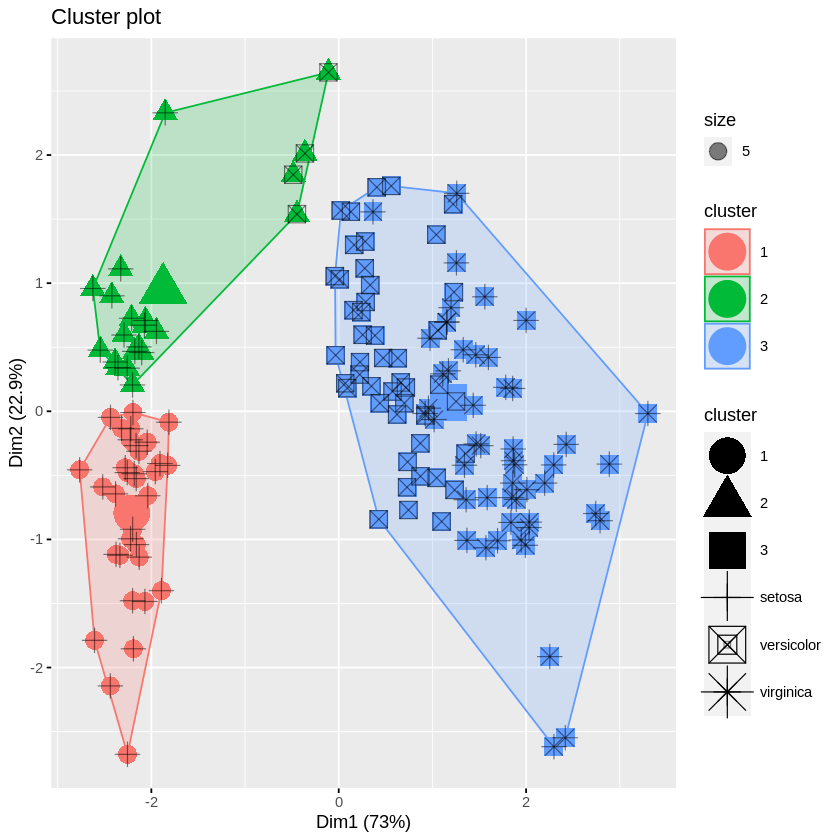

In [20]:
fviz_cluster(
    iris_kmeans, 
    data = iris_scale,
    geom = "point",
    pointsize = 5,
    show.clust.cent = TRUE) +
    geom_point(aes(shape = iris$Species, size = 5), alpha = 0.5)

# We plot with the fviz_cluster function in factoextra package
# We set geom to point so labels don't muck up the space
# We add an extra point to each cluster representing the centroid, that is, the mean of each cluster
# We overlay the species data as different shapes

Once again, we see that setosa separates cleanly.  Virginica and versicolor mostly cluster separately but there is still overlap.

---

## Conclusions

Exploratory analysis is more of a philosophy than a set defined techniques, and thus we've only touched on a few of the most common techniques here and will cover them in more detail with omics data in <b>Submodule 4: Exploratory Analysis of Proteomics IRI Data</b>.  <b>Submodule 5: Identification of IRI Biomarkers from Proteomic Data</b> will also look at omics-specific plots such as MA-plots and volcano plots that are useful for getting a broad view of expression patterns.

---

## Quizes

In [ ]:
IRdisplay::display_html('<iframe src="quizes/Chapter4_Quizes.html" width=100% height=450></iframe>')

---

## References

### Core Reading
[Tabachnick BG, Fidell LS: Using Multivariate Statistics (7th Edition). 2021, Pearson Education Inc.][Tabachnick]<br>
[Everitt B, Holthorn T: An Introduction to Applied Multivariate Analysis with R. 2011, Springer Science+Business Media][Everitt]<br>

[Tabachnick]: https://www.pearson.com/en-us/subject-catalog/p/using-multivariate-statistics/P200000003097/9780137526543 "Tabachnick BG, Fidell LS: Using Multivariate Statistics (7th Edition). 2021, Pearson Education Inc."
[Everitt]: https://link.springer.com/book/10.1007/978-1-4419-9650-3 "Everitt B, Holthorn T: An Introduction to Applied Multivariate Analysis with R. 2011, Springer Science+Business Media"

---